# Skip-gram Word2Vec

## Загрузка данных для обучения

>* Загружаем корпус рускоязычных новостей c https://tatianashavrina.github.io/taiga_site/downloads 
* Оставляем только новости Интерфакса
* Объединяем все txt-файлы вместе и создаем свой собственный датасет в `Data.txt`

Все перечисленные выше пункты были выполнены и все данные уже лежат в файле Dataset.txt (код, при помощи при помощи которого это было выполнено, приведен ниже)

In [1]:
import os

# texts = ''

# for f in os.listdir('Interfax/texts/'):
#     txt = open('Interfax/texts/' + f).read()
#     texts += txt   

# file = open("Data.txt","a")
# file.write(texts)
# file.close() 

In [2]:
with open('Data.txt') as f:
    text = f.read()

## Предобработка данных

Чтобы сделать обучение проще, в файле `utils.py` была реализована функция `preprocess`, которая выполняет следующее:

>* Превращает любую пунктуацию в токены, так что, например, точка превращается в  ` <PERIOD> `. 
* Удаляет все слова, которые появляются в датасете 5 или *менее* раз. Это поможет решить проблему зашумления данных и значительно улучшит качество векторного представления слов, которое будет реализовано в word2vec 
* Возвращет список слов в тексте.

In [3]:
import utils

words = utils.preprocess(text)

#np.save('words.npy', words)
#words = np.load('words.npy')

In [4]:
print(words[:30])

['шеф-редактор', '<quotation_mark>', 'новый', 'газета', '<quotation_mark>', 'сергей', 'соколов', 'в', 'ближний', 'время', 'смочь', 'вернуться', 'в', 'москва', '<period>', '<quotation_mark>', 'получаться', 'так', '<comma>', 'соколов', 'мочь', 'возвращаться', 'в', 'россия', '<comma>', 'взаимный', 'извинение', 'произнести', '<quotation_mark>', '<comma>']


In [5]:
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in text: 9069869
Unique words: 31289


### Создание словарей

Далее, мы создадим два словаря, чтобы превращать слова в натуральные числа и наоборот (числа в слова). Это реализовано при помощи функции `create_lookup_tables` в файле `utils.py`. Она принимает на вход список слов и возвращает два словаря.

После того как словари были созданы, слова кодируются цифрами и хранятся в массиве `int_words`.

In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[11429, 4, 136, 319, 4, 108, 4095, 3, 302, 48, 335, 660, 3, 38, 2, 4, 3682, 105, 1, 4095, 53, 2296, 3, 15, 1, 4476, 3355, 8768, 4, 1]


## Subsampling

Слова, которые появляются в тексте довольно часто (например, различные предлоги или знаки препинания), не всегда несут много информации о тех словах, что находятся рядом с ними. Если мы уберем некоторые из них, то, таким образом, мы сможем удалить шум из данных и обеспечить более быструю тренировку и лучшие векторные представления слов.  Для каждого слова $w_i$ в тренировочном датасете мы удаляем его с вероятностью

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

где $t$ - пороговый параметр и $f(w_i)$ - частота появления слова $w_i$ во всем датасете.

In [7]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[11429, 4095, 3682, 105, 4095, 53, 3355, 8768, 4, 7570, 72, 2684, 9031, 2885, 124, 13472, 3934, 8235, 22525, 2807, 4404, 6182, 6708, 2807, 8109, 670, 773, 707, 45, 2477]


## Создание батчей

После того как мы предобработали наши данные, мы должны объединить их в батчи, чтобы передавать их на вход нашей нейронной сети. Мы будем использовать skip-gram архитектуру. Для каждого слова в тексте мы хотим определить окружающий его _контекст_ и взять все слова из окна размера $C$ с центром в интересующем нас слове.

Из [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

Это реализовано при помощи функции `get_target` из файла `batch_generation.py`.

В файле `batch_generation.py` реализован генератор `get_batches`, который возврашает батчи данных для нашей модели, используя функцию `get_target`, о которой было сказано выше.

In [8]:
from batch_generation import *

### Примеры работы нашего генератора

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 1, 3, 0, 1, 2]


---
## Валидация

Далее реализована функция, которая поможет нам наблюдать за обучением нашей модели. Для этого мы будем использовать косинусную меру.

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

Мы можем закодировать слова, используемые для валидации, как векторы $\vec{a}$ при помощи таблицы эмбеддингов и затем посчитать их "схожесть" со случайно выбранными из нашего словаря словами, закодированными как $\vec{b}$. 

Таким образом, при обучении мы можем видеть, какие слова наша модель считает "наиболее схожими" со словами, используемыми для валидации.



In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # Выбираем N слов из диапазона (0,window) и (1000,1000+window) 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram модель

Определим и натренируем SkipGram модель. 

Она реализована в файле `model.py`

Чтобы сделать тренировку более эффективной мы будем использовать ошибку под названием  ["negative sampling loss"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), которая определяется как

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

Как и описано в [статье](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) мы примем $P_n(w)$ = $U(w)^{3/4}$.

Данная ошибка реализована в файле `loss.py`.

In [11]:
import torch
from torch import nn
import torch.optim as optim
from model import SkipGramNeg
from loss import NegativeSamplingLoss

### Натренируем нашу модель

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Определим шумное распределение, из которого будем сэмплировать слова для второго слагаемого нашего лосса
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# Инициализируем модель
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 10

# Тренируем заданное выше количество эпох
for e in range(epochs):
    
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Для каждой эпохи будем выводить среднюю ошибку и валидировать модель при описанного выше метода
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item())
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/10
Loss:  5.386521816253662
после | базис, один, в, подойти, цена
<left_paren> | подняться, сурков, пфр, икра, корт
ещё | ралли, желать, ажиотаж, таганско-краснопресненский, динамовский
к | земельный, объездной, должность, выбраться, хороший
представитель | один, мануэль, <period>, <quotation_mark>, <comma>
<semicolon> | соорганизатор, размышление, шарафуллин, чернов, разблокировать
весь | сента, ровд, мк, кондитерский, cis-emo
президент | конкуренция, мотивированный, гостайна, прорываться, камаз-мастер
собянин | мощный, дмитрия, самолёт, тренировка, -
идея | казахстан, росберг, проявление, колония-поселение, содействие
кремль | 62', инфаркт, союз, песчаный, ажиотаж
положение | планировать, захват, камчатка, забыть, renault
нынешний | потомок, юзао, постановление, торжественно, нерентабельный
объём | оторваться, мишель, страшный, рациональный, 64%
красный | спорт, кубанский, луиш, 1%, талиб
назначение | cib, вправе, ступка, иван, главка
...

Epoch: 1/10
Loss:  4.07351732254028

Epoch: 5/10
Loss:  2.1453750133514404
<right_paren> | <left_paren>, 1, <comma>, 2, 0
это | и, <comma>, он, если, а
власть | призыв, человек, <comma>, немедленный, призвать
то | я, не, только, они, если
весь | и, не, <comma>, они, который
они | весь, какой-то, то, тот, и
работа | ситуация, в, работать, создание, и
суд | арест, жалоба, обжаловать, ходатайство, приговор
татарстан | казань, су, подозревать, следственный, муфтий
справедливый | лдпр, левичев, кпрф, фракция, эсер
кндр | пхеньян, северокорейский, корея, южнокорейский, ракета
выходить | замена, вместо, <exclamation_mark>, 45', 73'
52 | <semicolon>, interfax, //www, http, &quot
будущее | создание, новый, достижение, думать, поколение
поддерживать | политический, считать, диалог, тема, поддержать
падение | упасть, рухнуть, 45, мск, 17
...

Epoch: 5/10
Loss:  2.2625670433044434
20 | <semicolon>, interfax, <colon>, интерфакс, <period>
как | который, слово, <comma>, <quotation_mark>, один
на | <period>, в, интерфакс, <colon>, <semic

Epoch: 9/10
Loss:  2.0661752223968506
свой | <comma>, <quotation_mark>, <period>, что, в
к | и, на, <comma>, свой, а
заявить | что, представитель, <quotation_mark>, <comma>, подчеркнуть
но | не, вот, а, <comma>, и
интерфакс | //www, <semicolon>, interfax, http, 17
должный | быть, тот, мы, для, то
то | не, если, я, говорить, же
информация | сведение, источник, располагать, что, <period>
прийти | кто, мнение, много, так, собраться
будущее | мы, поколение, оно, то, хотеть
киев | украина, тимошенко, печерский, экс-премьера, интерфакс-украина
проголосовать | избиратель, голосование, парламент, голосовать, выборы
анжи | махачкалинский, махачкалинец, зенит, габул, это'ый
пилот | гонщик, caterham, самолёт, разбиться, автоспорт
поставить | быть, владимир, надо, должный, контрактация
ущерб | причинить, возмещение, возместить, сумма, компенсация
...

Epoch: 9/10
Loss:  2.006673812866211
с | <comma>, <period>, и, <quotation_mark>, в
суд | жалоба, арест, приговор, отклонить, адвокат
<quotation_mark

## Визуализируем полученные векторные представления слов

Будем использовать T-SNE, чтобы перевести наши векторные представления слов высокой размерности в двумерное пространство.

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [14]:
# достанем все полученные эмбеддинги из нашей модели
embeddings = model.in_embed.weight.to('cpu').data.numpy()
#np.save('embeddings.npy', embeddings)

In [19]:
viz_words = 250
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

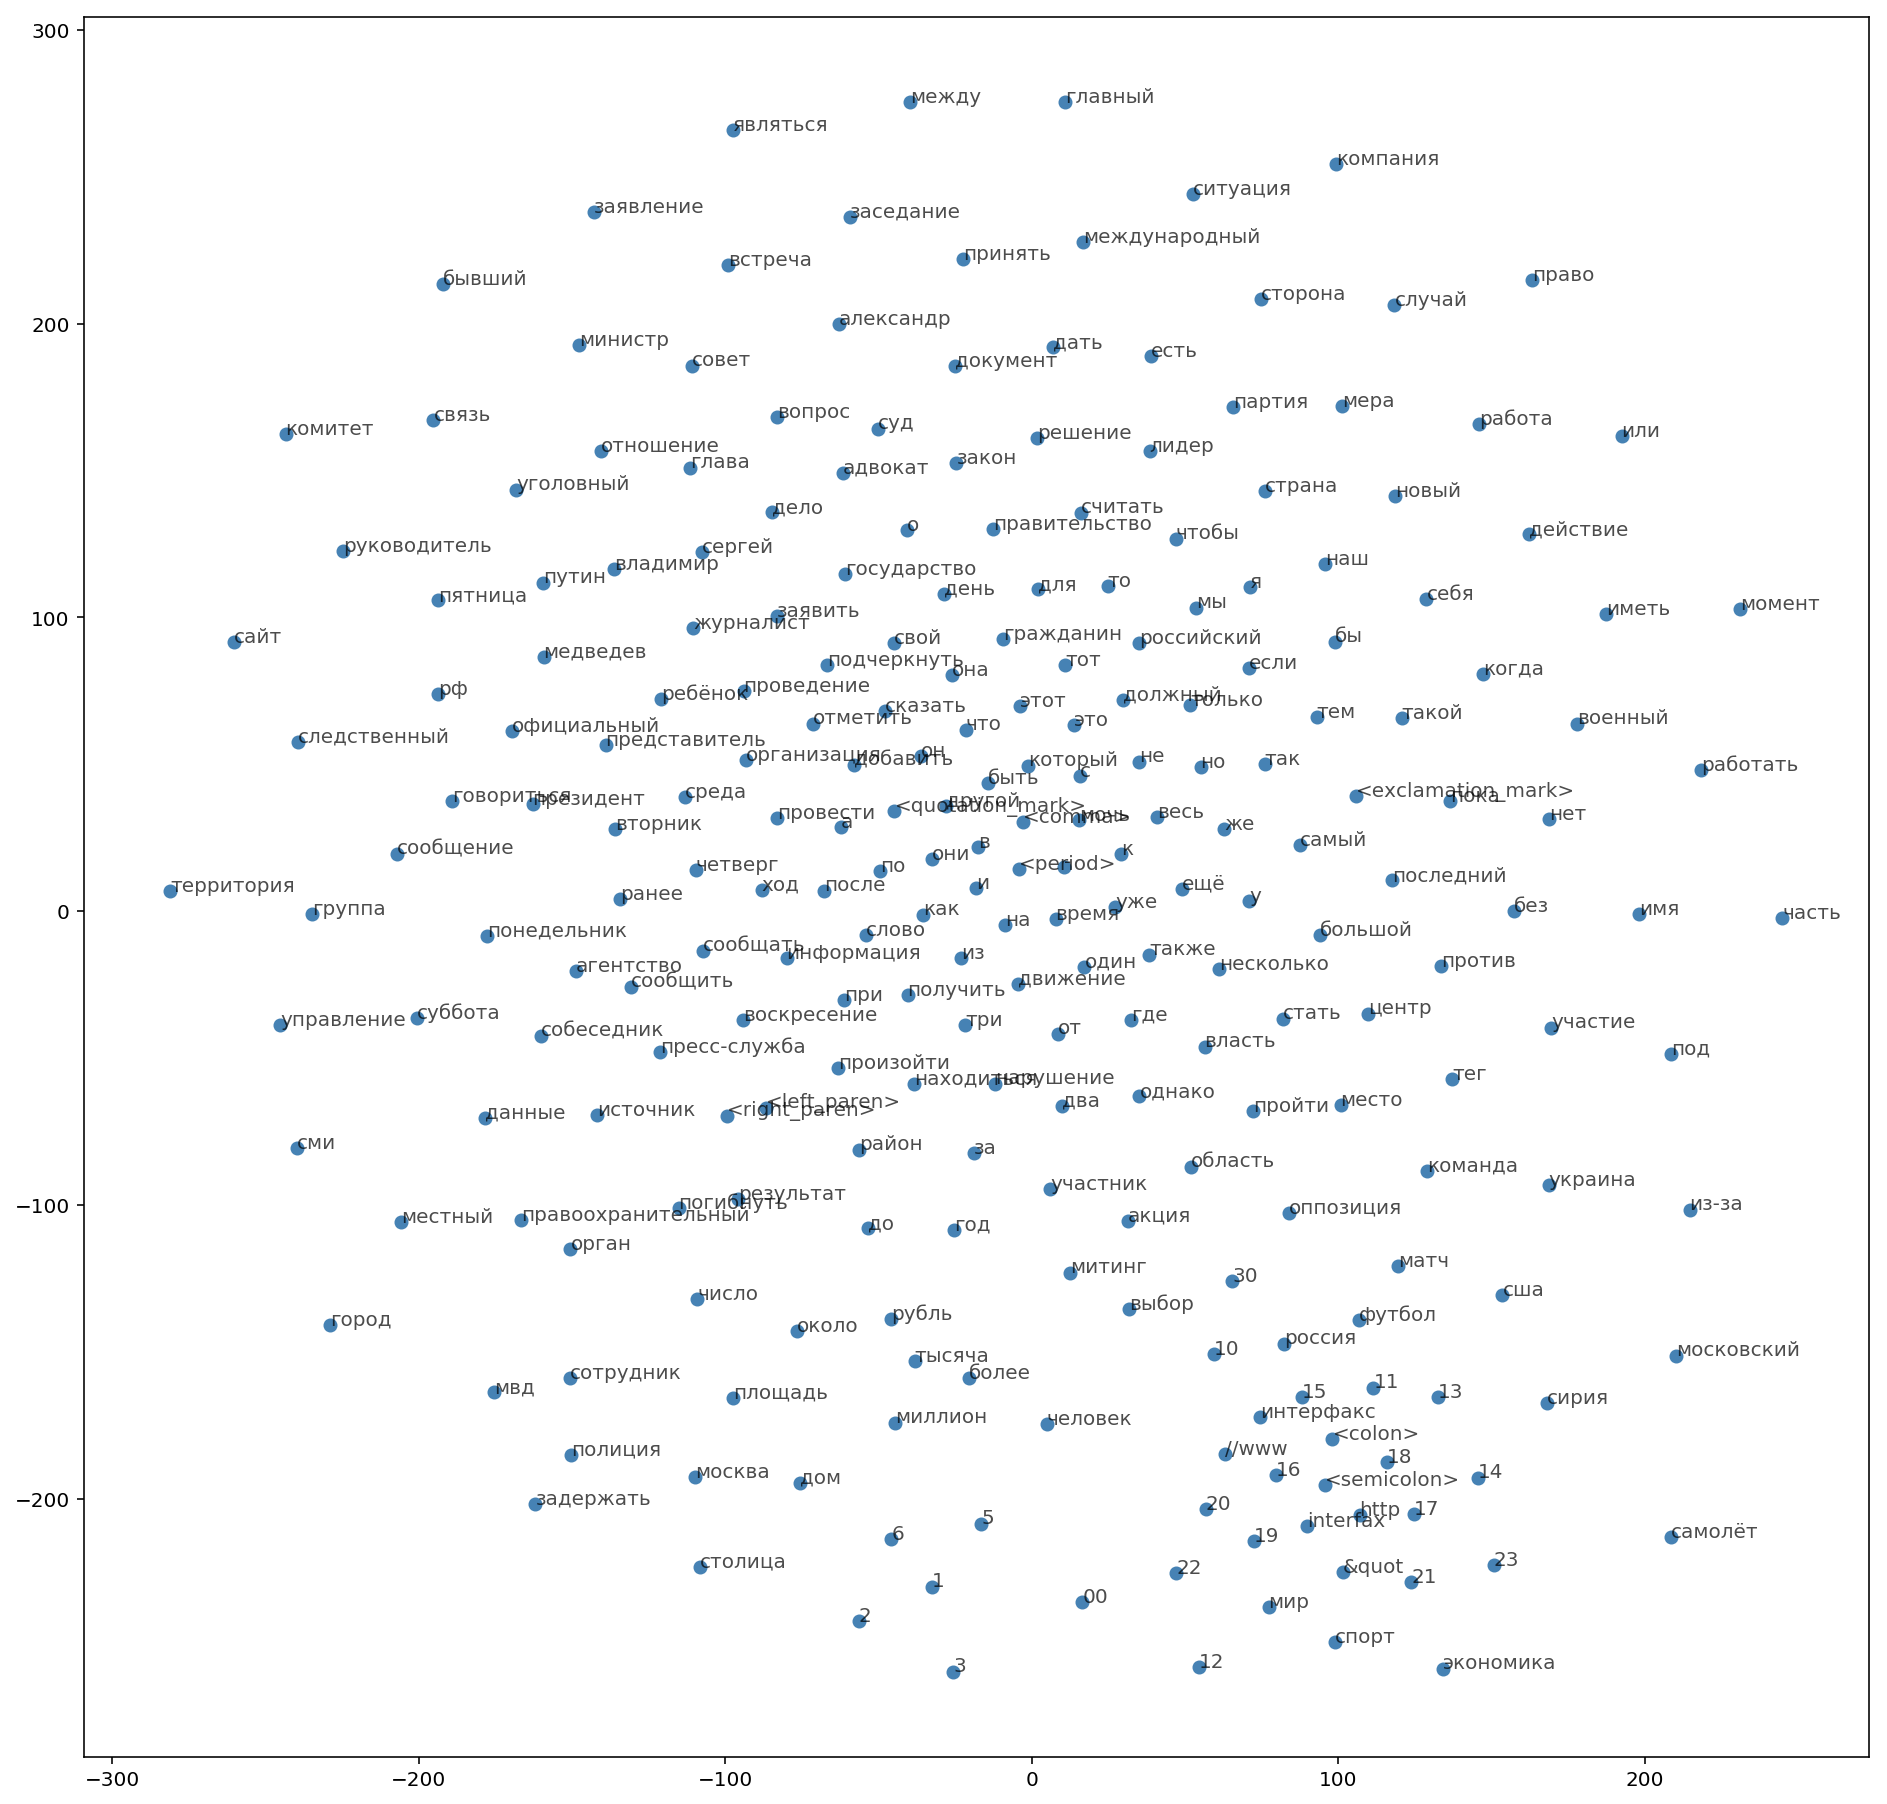

In [20]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

По картинке можно видеть, что у нас получились довольно интересные результаты, и наша модель хорошо научилась группировать семантически близкие друг к другу слова.

## Протестируем полученные эмбеддинги в задаче классификации

Загрузим датасет Лента, выберем только нужные нам для классификации столбцы и удалим все пустые значения

In [21]:
import pandas as pd

data = pd.read_csv('~/data/lenta-ru-news.csv')

In [22]:
df = data[['text', 'topic']].dropna().reset_index(drop=True)

In [23]:
print('Total texts in dataset: {}'.format(df.shape[0]))

Total texts in dataset: 739143


Сначала предобработаем все тексты из датасета. Это занимает довольно продолжительное время, поэтому для это был написан отдельный скрипт `preprocess.py`. После его выполнения все токенизированный и лематизированные тексты сохраняются в файле `tokenized_texts.npy`.

In [24]:
#!python preprocess.py

In [25]:
tokenized_texts = np.load('tokenized_texts.npy')

Посмотрим на распределение текстов по темам в нашем тестовом датасете

In [26]:
df['topic'].value_counts()

Россия               160516
Мир                  136679
Экономика             79538
Спорт                 64421
Культура              53802
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

Мы можем видеть, что на такие темы как `Оружие`, `ЧМ-2014`, `Сочи` и `МедНовости` приходятся очень маленькое количество текстов, и в целом выборка очень несбалансированная. Удалим эти темы из нашего датасета для улучшения обучения.

In [27]:
indx_to_drop = []

for i, topic in enumerate(df['topic'].values):
    if topic == 'Оружие' or topic == 'ЧМ-2014' or topic == 'Сочи' or topic == 'МедНовости':
        indx_to_drop.append(i)

In [28]:
tokenized_texts = np.delete(tokenized_texts, indx_to_drop)

Для каждого текста посчитаем среднее эмбеддингов всех слов, входящих в этот текст. Причем, если вдруг нам попался текст, в котором нет не одного слова из нашего словаря, то мы будем считать, что для такого текста средний эмбеддинг есть нулевой вектор.

Таким образом, для каждого текста мы получим вектор размера `embedding_dim`. Этот вектор мы и будем считать вектором признаков в нашей дальнейшей задачи классификации.

In [29]:
from tqdm import tqdm

def embedding_mean(tokenized_text, dictionary):
    return np.array([embeddings[vocab_to_int[word]] for word in tokenized_text if word in dictionary]).mean(axis=0)

dictionary = set(words)

means = []

for entry in tqdm(tokenized_texts):
    mean = embedding_mean(entry, dictionary)
    if np.isnan(mean).any():
        means.append(np.zeros((embedding_dim,)))
    else:
        means.append(mean)

 66%|██████▌   | 484979/739136 [02:56<01:23, 3039.68it/s]/opt/conda/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/opt/conda/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 739136/739136 [04:22<00:00, 2811.88it/s]


In [30]:
#Метки классов (темы новостей)
labels = np.delete(df['topic'].values, indx_to_drop)

In [31]:
assert len(means) == len(labels)

Наконец, для того, чтобы протестировать наши эмбеддинги на задаче классификации, разделим полученные данные на обучающую и тестовую выборки.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(means, labels, 
                                     test_size=0.3, 
                                     random_state=0,
                                     stratify=labels)


Обучим модель логистической регрессии и посчитаем метрику accuracy на каждой из выборок.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
pred = model.predict(means)

print('Accuracy on train: {}'.format(accuracy_score(train_pred, y_train)))
print('Accuracy on test: {}'.format(accuracy_score(test_pred, y_test)))
print('Accuracy on whole dataset: {}'.format(accuracy_score(pred, labels)))
      

Accuracy on train: 0.7725277592555011
Accuracy on test: 0.7723425077004252
Accuracy on whole dataset: 0.7724721837388518


В итоге мы получили довольно хорошие результаты на обучающей и тестовой выборках. Осталось сохранить результаты.

In [46]:
if not os.path.exists('results'):
    print("Making directory", 'results')
    os.mkdir('results')
np.savetxt('results/predictions.txt', pred, fmt='%s')